In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr 
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import pingouin as pg

In [39]:
# (1) Load the CSV data 'one target' dataset
raw_data = pd.read_csv('data/testmybrain_clean_onetar_2March2023.csv')
raw_data = raw_data.sort_index(axis=1)
print(raw_data.columns)
print(pd.unique(raw_data['racialorigin']))

Index(['Age', 'Block', 'CCW', 'CN', 'ComputerUsage', 'FB', 'Group', 'HandFlip',
       'Hand_raw', 'Handedness', 'MT', 'NeuroDisease', 'NeuroDiseaseDescribe',
       'RT', 'ST', 'Sleep', 'StartTime', 'Subject.ID', 'TN', 'browsertype',
       'clumsy', 'education', 'endtime', 'gameIndex', 'major', 'mousetype',
       'numtar', 'racialorigin', 'rating', 'repeat.', 'ri', 'screenheight',
       'screenwidth', 'seedisplay', 'sex', 'technical', 'ti', 'videogames',
       'vision'],
      dtype='object')
['african-american' 'asian' 'white' 'rathernotsay' 'indian/native'
 'noneoftheabove' 'latinx' 'multiple' 'pacific-islander']


In [41]:
# (2) Preprocess data
df = raw_data.copy()

# CCW
df['CCW'] = df['CCW'].map({True:1, False : 0})

# Handedness
df['Handedness'] = df['Handedness'].map({'righth':'right', 'lefth':'left','bothh':'ambi'})

# Neurodisease
Neurodisease = {'No':0, ' ': 0, np.nan:0, 
               'AD':1, 'CD':1, 'MS':1,
               'Other':1, 'PD':1, 'Stroke':1}
df['NeuroDisease'] = df['NeuroDisease'].map(Neurodisease)

#clumsy
clumsiness = {'Strongly Disagree':0, 'Disagree':1, 'Neutral' :2,'Agree': 3, 'Strongly Agree': 4}
df['clumsy'] = df['clumsy'].map(clumsiness)

# education 
education = {
    'rathernotsay': -1, 'noneoftheabove': 0,
    'primaryschool': 1, 'middleschool': 2,
    'secondaryschool': 3, 'college': 4,
    'technicalschool': 4, 'bachelor': 5,
    'graduate': 6
}
df['education'] = df['education'].map(education)

# Mouse type
df['mousetype'] = df['mousetype'].replace({'idk': 'other','trackball': 'other'})

# rating 1-5
rating = {'1star':1, '2star':2, '3star':3, '4star':4, '5star':5}
df['rating'] = df['rating'].map(rating)

# screensize
df['screensize'] = df['screenwidth'] * df['screenheight']
df.drop(['screenwidth','screenheight'], axis=1, inplace=True)

# (F) cardinal -> 0/1
df['cardinal'] = df['ti'].apply(lambda x: 1 if x in [0, 90, 180, 270] else 0)

# videogames
df['videogames'] = df['videogames'].map(clumsiness)

# vision -> 
df['vision'] = df['vision'].apply(lambda x: 1 if str(x).lower() == 'yes' else 0)

# mov_avg (3-point moving average of HandFlip)
df['mov_avg'] = df['HandFlip'].rolling(window=3).mean()

# variability
df['variability'] = (df['mov_avg'] - df['HandFlip']).abs()

# Remove rows where education == -1 or racialorigin == 'rathernotsay'
df = df[df['education'] != -1]
df = df[df['racialorigin'] != 'rathernotsay']


In [43]:
# (3) create summary tables for early, late, aftereffect

# store demographic variable names 
demo_var = ['Subject.ID', 'Age', 'browsertype','cardinal','CCW','clumsy','ComputerUsage','education','Handedness','major', 'mousetype','NeuroDisease',
            'racialorigin', 'rating','screensize','sex','Sleep','videogames','vision']

#### mean of hand angles over early adaptation trials
early_data = (df[(df['TN'] >= 31) & (df['TN'] <= 41)]
           .groupby('Subject.ID', as_index = False)['HandFlip']
           .mean())
#### extract relevant trials to get average for other columns and other numerical variables
df_early_filter = df[(df['TN'] >= 31) & (df['TN'] <= 41)].copy()

#### look for demographic variables
df_early_filter = (df_early_filter
                  .groupby(demo_var,as_index = False, dropna = True)
                  .agg(RT_mean_baseline = ('RT','mean'),
                      MT_mean_baseline = ('MT','mean'),
                      ST_mean_baseline = ('ST','mean'),
                      var_sum_baseline = ('variability', 'sum')
                      ))
#### merge two tables
df_early = pd.merge(early_data, df_early_filter, on = 'Subject.ID', how = 'outer')
df_early = df_early.dropna()

df_late = (df[ (df['TN'] >= 74) & (df['TN'] <= 84)]
           .groupby('Subject.ID', as_index = False)['HandFlip']
           .mean()
)

df_ae = (df[(df['TN'] >= 85) & (df['TN'] <= 90)]
        .groupby('Subject.ID', as_index = False)['HandFlip']
         .mean()
        )

In [45]:
# convert categorical variables as dummy variables
var_categorical = ['browsertype','Handedness','major','mousetype','racialorigin','sex']
df_early = pd.get_dummies(df_early, columns = var_categorical,drop_first=False)

# score numerical variables
numerical_variables = ['HandFlip','Age','clumsy','ComputerUsage','education','rating', 'screensize', 'Sleep','MT_mean_baseline',
                      'RT_mean_baseline','ST_mean_baseline','var_sum_baseline','videogames']

scaler = StandardScaler()
df_early[numerical_variables] = scaler.fit_transform(df_early[numerical_variables] )

df_early = df_early.dropna()

In [47]:
df_early.columns

Index(['Subject.ID', 'HandFlip', 'Age', 'cardinal', 'CCW', 'clumsy',
       'ComputerUsage', 'education', 'NeuroDisease', 'rating', 'screensize',
       'Sleep', 'videogames', 'vision', 'RT_mean_baseline', 'MT_mean_baseline',
       'ST_mean_baseline', 'var_sum_baseline', 'browsertype_Chrome',
       'browsertype_Edge', 'browsertype_NotDetected', 'browsertype_Opera',
       'browsertype_Safari', 'browsertype_firefox', 'Handedness_ambi',
       'Handedness_left', 'Handedness_right', 'major_ArtsHum',
       'major_Business', 'major_Other', 'major_Psychology', 'major_STEM',
       'major_SocialScience', 'mousetype_optical', 'mousetype_other',
       'mousetype_trackpad', 'racialorigin_african-american',
       'racialorigin_asian', 'racialorigin_indian/native',
       'racialorigin_latinx', 'racialorigin_multiple',
       'racialorigin_noneoftheabove', 'racialorigin_pacific-islander',
       'racialorigin_white', 'sex_female', 'sex_male', 'sex_other'],
      dtype='object')

In [49]:
df_corr = df_early.copy()
# remove columns from the table which are not in the correlation matrix
drop_columns = ['Subject.ID','HandFlip']
df_corr = df_corr.drop(columns = drop_columns)

# corr_matrix
corr_matrix = df_corr.corr(method = 'pearson')

# create two dataframes to store pvalues and correlation coefficients
pvals = pd.DataFrame(np.ones_like(corr_matrix),
                    columns = corr_matrix.columns,
                    index = corr_matrix.index)

rvals = pd.DataFrame(np.ones_like(corr_matrix),
                    columns = corr_matrix.columns,
                    index = corr_matrix.index)

for col in corr_matrix.columns:
    for row in corr_matrix.columns:
        
        if col == row:
            pvals.loc[row,col] = np.nan
            rvals.loc[row,col] = np.nan
        else:
            r_val, p_val = pearsonr(df_corr[row],df_corr[col])
            pvals.loc[row,col] = p_val
            rvals.loc[row,col] = r_val
    

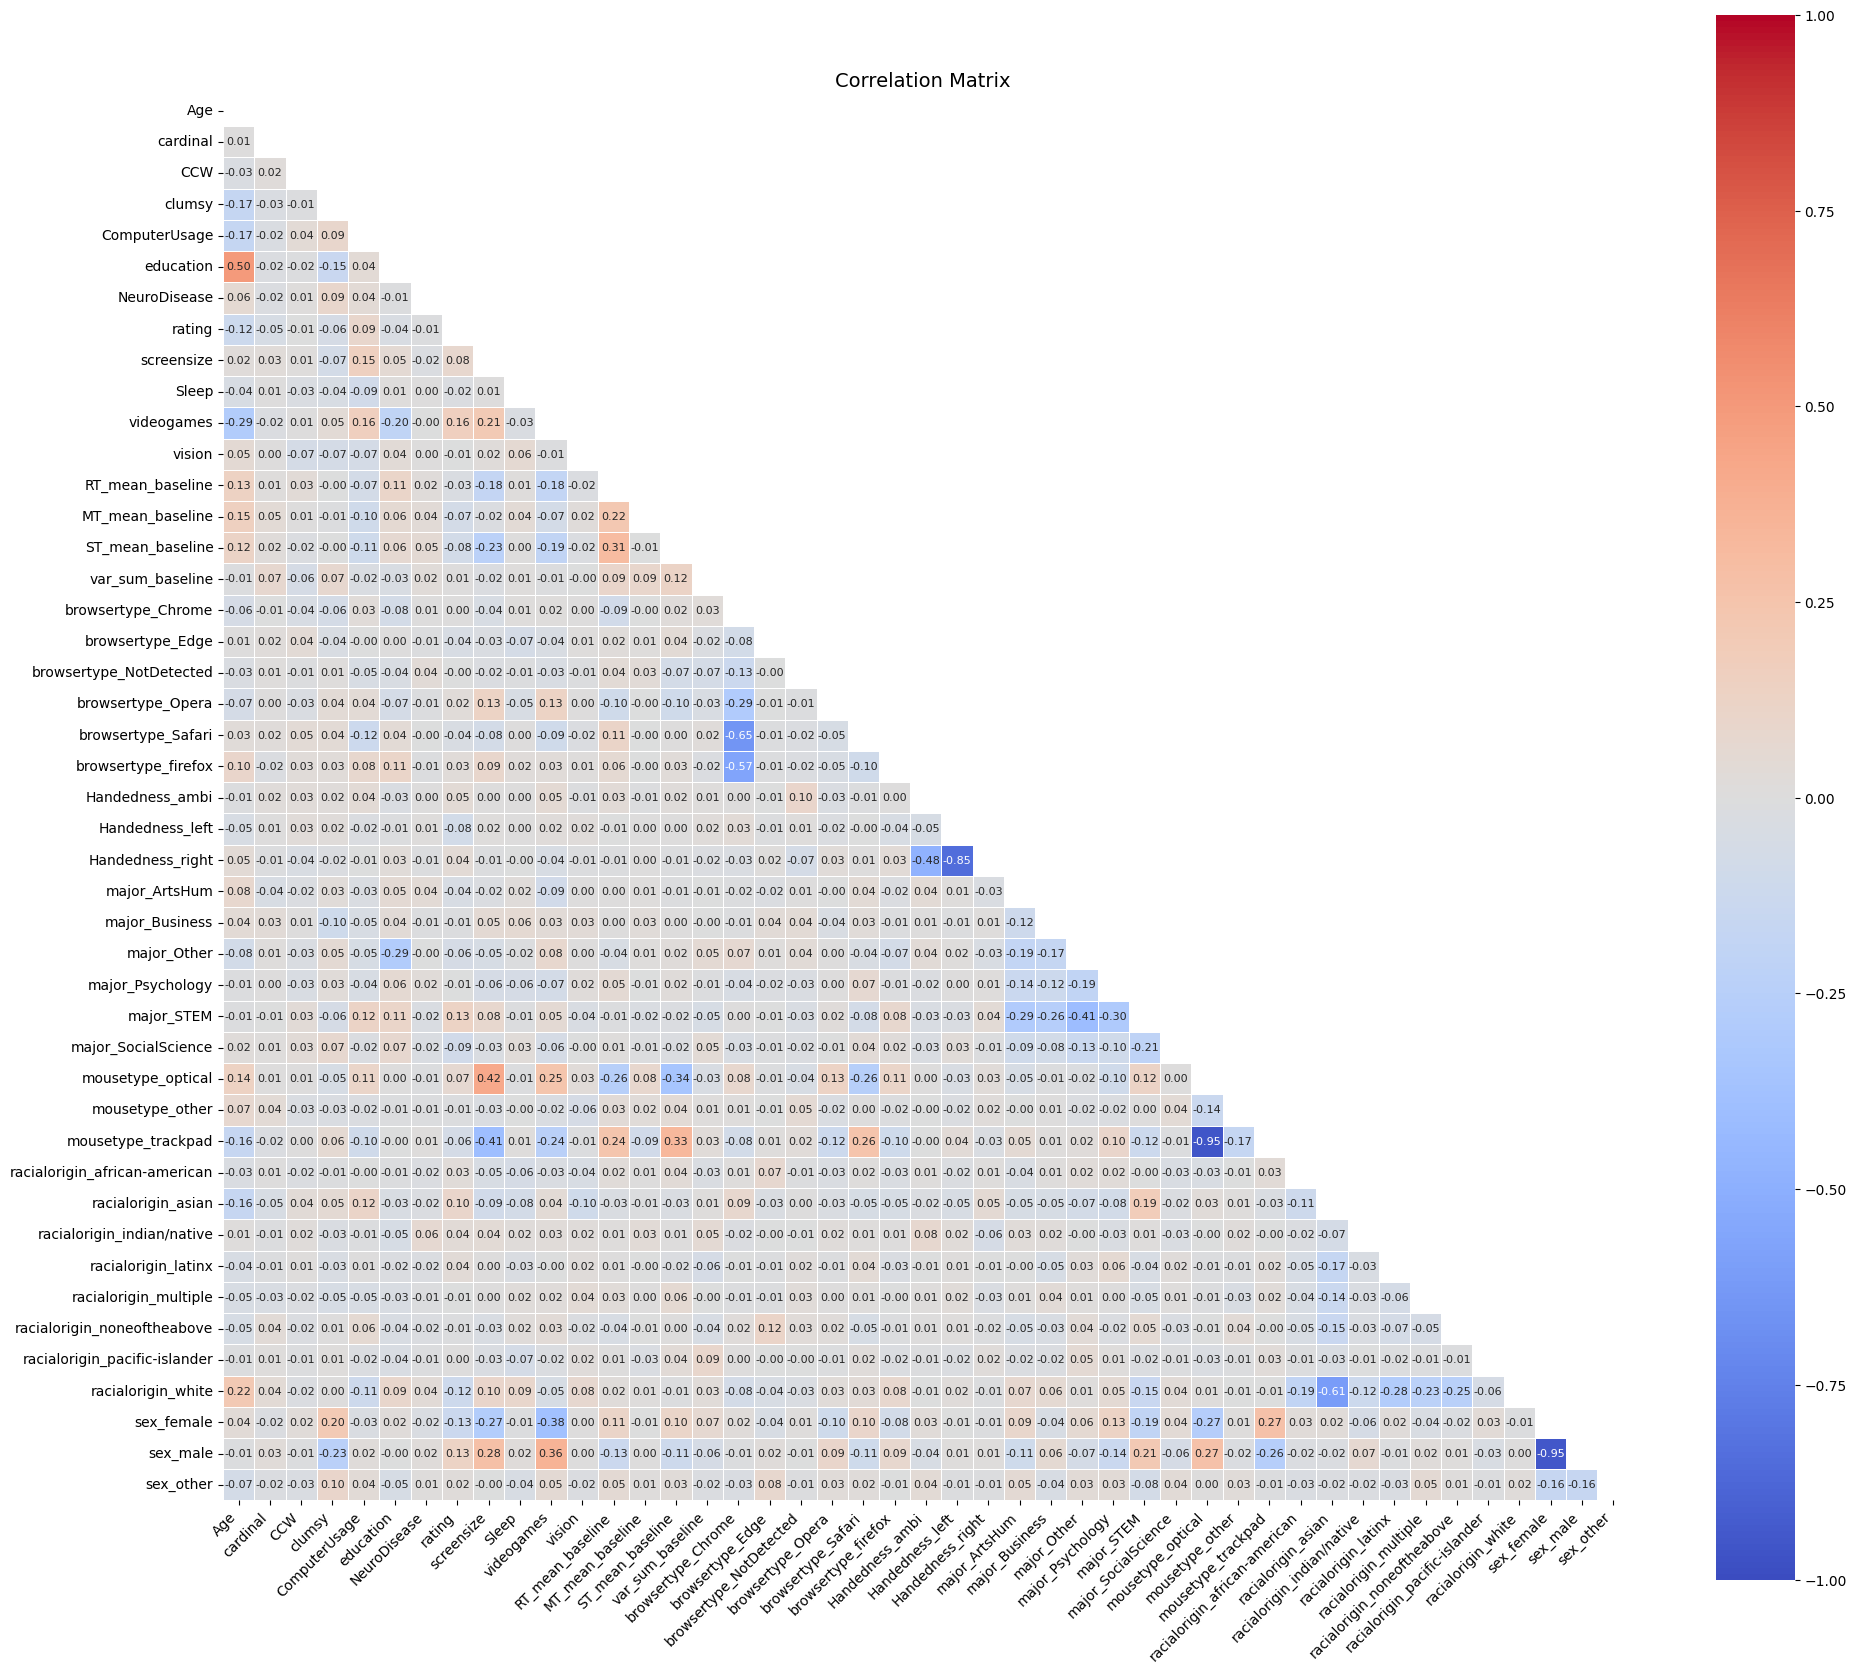

In [51]:
# plot the results
### create a mask for upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(20,20))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
            corr_matrix,
            mask=mask,
            annot = True,
            fmt = ".2f",
            cmap="coolwarm",
            vmin=-1, vmax=1,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .8},
            annot_kws = {"size": 8})
plt.title("Correlation Matrix ", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()




Our analyses accounted for the influence of
confounding variables, regressing out the influence of demographic
variables correlated with age (Extended Data Fig. 3; |r| > 0.2: years of
education, r = 0.46; 95% CI, (0.42, 0.50); t1745 = 21.7; P < 0.001; video
gaming experience, r = −0.28; 95% CI, (−0.32, 0.24); t1745 = −12.4;
P < 0.001)).

In [54]:
# demo variables correlated with age |r| > 0.2
sig_only = corr_matrix['Age'].where(rvals['Age'].abs() > 0.2)
rows = sig_only.dropna().index
print('Variables that correlate with Age (|r| > 0.2):', rows.tolist())
rvals_of_var = rvals.loc[rows,'Age']
print('\nr-values for those variables:\n',rvals_of_var)
pvals_of_var = pvals.loc[rows, 'Age']
print('\nP-values for those correlations:\n', pvals_of_var)

Variables that correlate with Age (|r| > 0.2): ['education', 'videogames', 'racialorigin_white']

r-values for those variables:
 education             0.495695
videogames           -0.287244
racialorigin_white    0.216531
Name: Age, dtype: float64

P-values for those correlations:
 education             5.695670e-100
videogames             9.071137e-32
racialorigin_white     1.977504e-18
Name: Age, dtype: float64


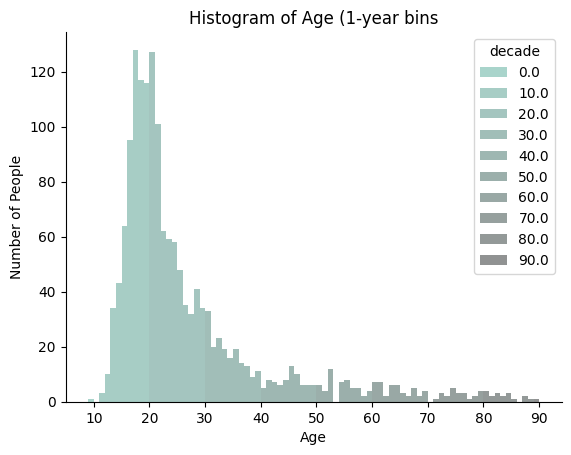

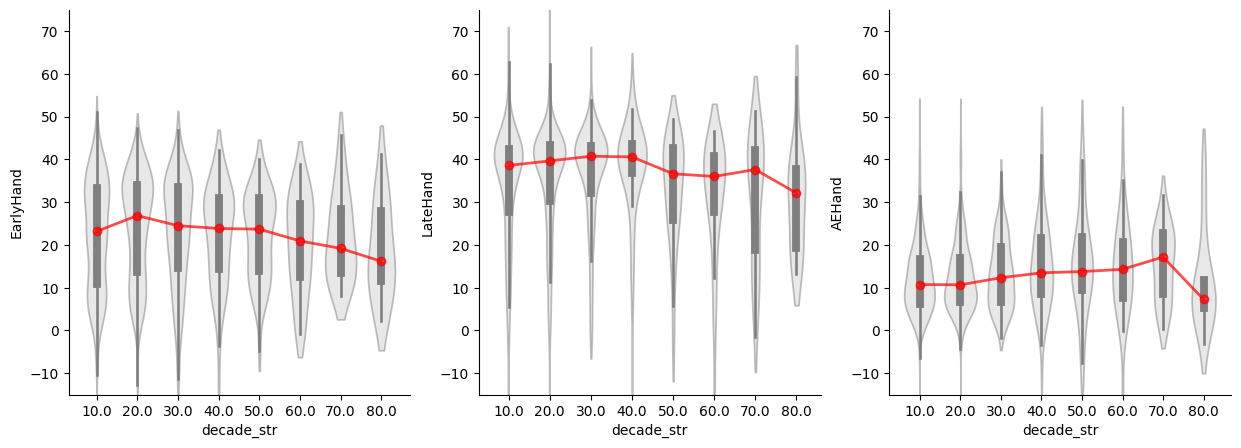

In [56]:
# violinplot of age vs Hand angle
early_data = early_data.rename(columns={'HandFlip': 'EarlyHand'})
df_late = df_late.rename(columns={'HandFlip': 'LateHand'})
df_ae = df_ae.rename(columns={'HandFlip': 'AEHand'})

df_merged = (
    df_early_filter[['Subject.ID','Age']]
    .merge(early_data, on='Subject.ID', how='outer')
    .merge(df_late, on='Subject.ID', how='outer')
    .merge(df_ae, on='Subject.ID', how='outer')
)
df_merged.head()

df_merged['decade'] = (df_merged['Age'] // 10) *10 

#plt.figure(figsize=(10,6))
sns.histplot(
    data=df_merged, 
    x='Age', 
    hue='decade',       
    binwidth=1,          
    palette='dark:#5A9_r',     
    edgecolor=None
)
sns.despine()
plt.xlabel('Age')
plt.ylabel('Number of People')
plt.title('Histogram of Age (1-year bins')
plt.show()


phases = ['EarlyHand','LateHand','AEHand']

df_merged['decade_str'] = df_merged['decade'].astype('str')
df_merged = df_merged[(df_merged['Age'] < 85) & (df_merged['Age'] >= 10) ]
df_merged['decade'] = (df_merged['Age'] // 10) *10 

fig, ax = plt.subplots(1,3,figsize = (15,5))
for i, phase in enumerate(phases):
    sns.violinplot(data = df_merged, x = 'decade_str', y = df_merged[phase],
                  color = 'lightgray', order=sorted(df_merged['decade_str'].unique()),
                   inner = 'box', cut = 1, alpha = 0.5,ax=ax[i])
    stats = df_merged.groupby('decade_str')[phase].agg(
        median='median', q25=lambda x: np.quantile(x, 0.25), q75=lambda x: np.quantile(x, 0.75)
        ).reset_index().sort_values('decade_str')
    ax[i].plot(stats['decade_str'], stats['median'], marker='o', color='red', alpha=0.7, lw=2)
    ax[i].set_ylim(-15,75)
    
sns.despine()

In [81]:
raw_data_anova = raw_data.copy()

video_rate = {'Strongly Disagree':-2, 'Disagree':-1, 'Neutral' :0,'Agree': 1, 'Strongly Agree': 2}
raw_data_anova['videogames_map'] = raw_data_anova['videogames'].map(video_rate)
# education 
education = {
    'rathernotsay': 0, 'noneoftheabove': 0,
    'primaryschool': 1, 'middleschool': 2,
    'secondaryschool': 3, 'college': 4,
    'technicalschool': 4, 'bachelor': 5,
    'graduate': 6}                        
raw_data_anova['education_map'] = raw_data_anova['education'].map(education)
######### early adaptation
df_early = (raw_data_anova[
        (raw_data_anova['TN'] >= 31) &
        (raw_data_anova['TN'] <= 41)
                  ]
        .groupby(['Subject.ID'],as_index=False)
        .agg({
            'HandFlip':'mean',
            'Age':'first',
            'education_map':'first',
            'videogames_map':'first'})
        .dropna()
        )
df_early['Age_sq'] = df_early['Age'] ** 2

####### late adaptation
df_late = (raw_data_anova[
        (raw_data_anova['TN'] >= 75) &
        (raw_data_anova['TN'] <= 84)
                  ]
        .groupby(['Subject.ID'],sort=False)
        .agg({ 
            'HandFlip':'mean',
            'Age':'first',
            'education_map':'first',
            'videogames_map':'first'})
        .reset_index()  
        .dropna()
        )
df_late['Age_sq'] = df_late['Age'] ** 2


######## After effect
df_ae = (raw_data_anova[
        (raw_data_anova['TN'] >= 85) &
        (raw_data_anova['TN'] <= 90)
                  ]
        .groupby(['Subject.ID'],sort=False)
        .agg({
            'HandFlip':'mean',
            'Age':'first',
            'education_map':'first',
            'videogames_map':'first' }) 
        .reset_index()
        .dropna()
        )
df_ae['Age_sq'] = df_ae['Age'] ** 2


# Anova early - Linear
model_early = ols(formula = 'HandFlip ~ Age + education_map + videogames_map', data = df_early).fit()
anova_res = anova_lm(model_early, typ = 3)
print(anova_res)
# Anova early - quadratic
model_early_q = ols(formula = 'HandFlip ~ Age + Age_sq+ education_map + videogames_map', data = df_early).fit()
anova_res_q = anova_lm(model_early_q, typ = 3)
print(anova_res_q)
print(model_early.aic - model_early_q.aic)
# partial eta-squared
ss_age = anova_res_q.loc['Age', 'sum_sq']
ss_residual = anova_res_q.loc['Residual', 'sum_sq']
eta_sq_age = ss_age / (ss_age + ss_residual)
print(eta_sq_age)

print('\n Anova Late Adaptation')
# Anova late - Linear
model_late_lin = ols(formula = 'HandFlip ~ Age + education_map + videogames_map', data = df_late).fit()
anova_res_late_lin = anova_lm(model_late_lin, typ = 3)
print(anova_res_late_lin)
# Anova late - quadratic
model_late_q = ols(formula = 'HandFlip ~ Age + Age_sq+ education_map + videogames_map', data = df_late).fit()
anova_late_res_q = anova_lm(model_late_q, typ = 3)
print(anova_late_res_q)
print(model_late_lin.aic - model_late_q.aic)
# partial eta-squared
ss_age = anova_late_res_q.loc['Age', 'sum_sq']
ss_residual = anova_late_res_q.loc['Residual', 'sum_sq']
eta_sq_age = ss_age / (ss_age + ss_residual)
print(eta_sq_age)

print('\n Anova after effect Adaptation')
# Anova aftereffect - Linear
model_ae_lin = ols(formula = 'HandFlip ~ Age + education_map + videogames_map', data = df_ae).fit()
anova_res_ae_lin = anova_lm(model_ae_lin, typ = 3)
print(anova_res_ae_lin)
# Anova afereffect - quadratic
model_ae_q = ols(formula = 'HandFlip ~ Age + Age_sq+ education_map + videogames_map', data = df_ae).fit()
anova_ae_res_q = anova_lm(model_ae_q, typ = 3)
print(anova_ae_res_q)
print(model_ae_lin.aic - model_ae_q.aic)
# partial eta-squared
ss_age = anova_ae_res_q.loc['Age', 'sum_sq']
ss_residual = anova_ae_res_q.loc['Residual', 'sum_sq']
eta_sq_age = ss_age / (ss_age + ss_residual)
print(eta_sq_age)

                       sum_sq      df           F         PR(>F)
Intercept       105604.285943     1.0  680.528693  6.316712e-127
Age                331.485852     1.0    2.136141   1.440436e-01
education_map      836.259569     1.0    5.388973   2.037920e-02
videogames_map    1110.444969     1.0    7.155862   7.541826e-03
Residual        270478.338651  1743.0         NaN            NaN
                       sum_sq      df           F        PR(>F)
Intercept        27455.400961     1.0  177.252214  1.383992e-38
Age                421.153678     1.0    2.718970  9.934227e-02
Age_sq             652.042153     1.0    4.209588  4.034532e-02
education_map      231.626342     1.0    1.495381  2.215489e-01
videogames_map    1180.583795     1.0    7.621855  5.826972e-03
Residual        269826.296498  1742.0         NaN           NaN
2.2165775364883302
0.0015584001926025389

 Anova Late Adaptation
                       sum_sq      df            F         PR(>F)
Intercept       233274.890979  